# Filtering Bird Data

Here we play around with filtering the raw meta data a few ways. Included in the meta data are the latitude and longitude coordinates associated with each audio file. We split the data as follows:
- We use two unsupervised learning methods to split the data into groups based on their geographic location. First we use K-means clustering to aggregate data into geographic clusters, which are then visualized on a world map. The "elbow method" is used to determine an appropriate number of clusters.
- The second unsupervised learning method we try on the original raw data is DBSCAN clustering. We similarly use this method to aggregate data into geographic clusters, which are again visualized on a world map.
- The third method we use to filter the data is to first map the latitude-longitude coordinate pairs to their corresponding countries, and then filter by country or countries. We demonstrate this by filtering out data below an audio quality threshold and outside of the US, Canada, and Mexico. 

First we import all of the necessary packages.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import reverse_geocode

from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

Here we import the training meta data from a csv file into a pandas dataframe. Each row corresponds to an element in the training data set—i.e. an audio file.

In [2]:
# Read in the training meta data from 'train_metadata.csv'
train_meta = pd.read_csv('train_metadata.csv',usecols=['primary_label','latitude','longitude','common_name','date','filename','rating'])
train_meta.iloc[:,:] # Sneak peek of the dataframe

,primary_label,latitude,longitude,common_name,date,filename,rating
0,acafly,35.3860,-84.1250,Acadian Flycatcher,2012-08-12,XC109605.ogg,2.5
1,acafly,9.1334,-79.6501,Acadian Flycatcher,2000-12-26,XC11209.ogg,3.0
2,acafly,5.7813,-75.7452,Acadian Flycatcher,2012-01-10,XC127032.ogg,3.0
3,acafly,4.6717,-75.6283,Acadian Flycatcher,2009-06-19,XC129974.ogg,3.5
4,acafly,4.6717,-75.6283,Acadian Flycatcher,2009-06-19,XC129981.ogg,3.5
...,...,...,...,...,...,...,...
62869,yetvir,30.2150,-97.6505,Yellow-throated Vireo,2020-07-10,XC591680.ogg,1.0
62870,yetvir,42.3005,-72.5877,Yellow-throated Vireo,2019-05-31,XC600085.ogg,5.0
62871,yetvir,42.3005,-72.5877,Yellow-throated Vireo,2020-06-02,XC602701.ogg,4.5
62872,yetvir,32.2357,-99.8811,Yellow-throated Vireo,2019-04-27,XC614733.ogg,4.0


Now that we've seen the dataframe, we use the geographic data and geopandas to visualize the geographic distribution of the data.

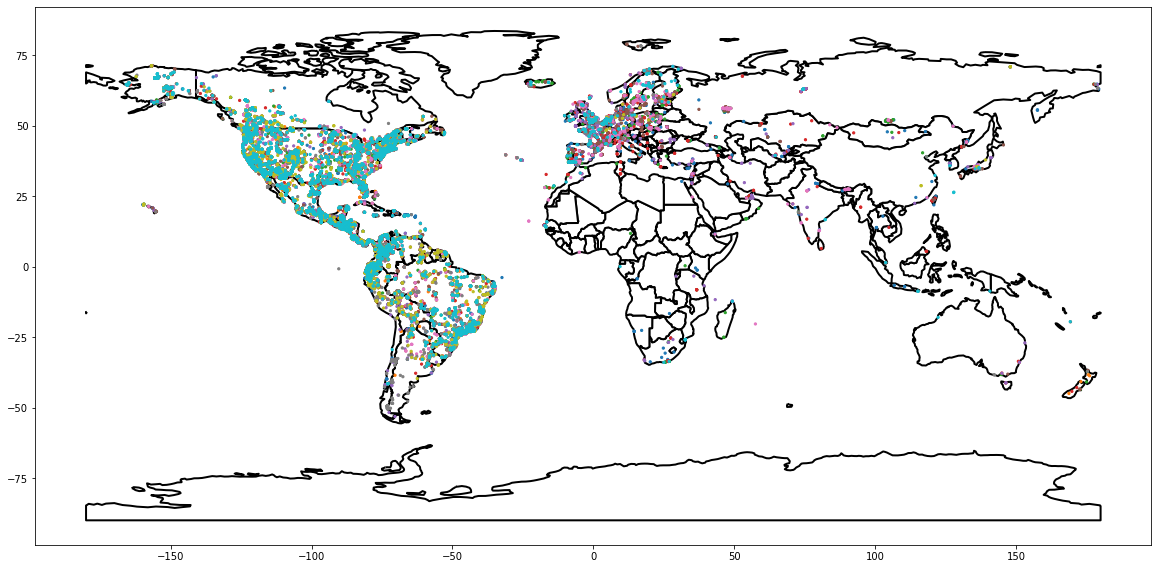

In [3]:
# Create a geodataframe from the latitudes and longitudes associated with the training data
gdf = gpd.GeoDataFrame(
    train_meta, geometry=gpd.points_from_xy(train_meta.longitude, train_meta.latitude))

# Initiate the plot
fig, ax = plt.subplots(figsize = (20,16))

# Import a map of the world to overlay the data upon
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(color='white',edgecolor='k',linewidth = 2,ax=ax)

# Plot the training data, where the color of the plotted points are determined by
# primary label (bird type).
gdf.plot(column='primary_label',categorical=True,markersize=5,ax=ax)
plt.show()

## Method 1: K-means Clustering

Here we perform K-means clustering using the geographic data. We vary the number of clusters from 2 to 25 and use the "elbow method" to determine an appropriate number of clusters. The "elbow method" essentially has to do with diminishing returns.

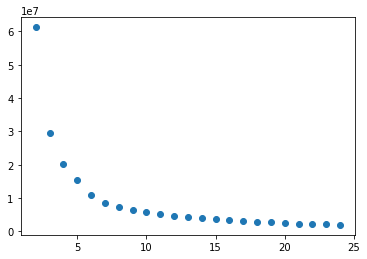

In [4]:
# Create a numpy array of latitude-longitude pairs associated with the training data.
X = np.column_stack((train_meta['latitude'].values,train_meta['longitude'].values))

# Initiate ssd (sum of squared distances) and cluster_no
ssd = []
cluster_no = []

# Perform K-means clustering for i=2 to i=25 clusters. We calulate the inertia
# (i.e. sum of squared distance from centroid over all elements in a given cluster
# and over all clusters) for each i and plot them against the number of clusters.
for i in range(2,25):
    km = KMeans(n_clusters=i, random_state=0)
    cluster_no.append(km.fit_predict(X))
    ssd.append(km.inertia_)

plt.scatter(np.arange(2,25),ssd[:])
plt.show()

Using the "Elbow Method": Looks like 7 or 8 is probably good.

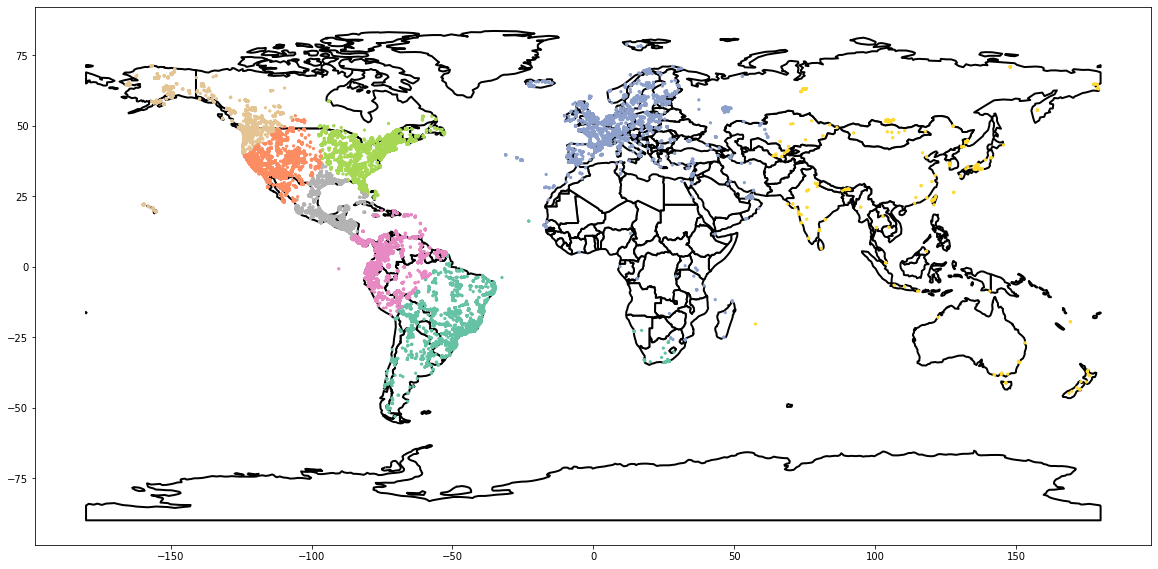

In [23]:
# Create a dataframe containing the clusters generated by K-means clustering with 
# 7 clusters.
clusters = pd.DataFrame(cluster_no[6], columns=['cluster'])

# Join the clusters and gdf (geodataframe—latitudes and longitudes) dataframes.
gdf_c=gdf.join(clusters)

# Initialize plot
fig, ax = plt.subplots(figsize = (20,16))

# Plot blank world map and overlay clusters on it.
world.plot(color='white',edgecolor='k',linewidth = 2,ax=ax)
gdf_c.plot(column='cluster',cmap='Set2',markersize=5,ax=ax)
plt.show()

## Method 2: DBSCAN

Here we try the unsupervised learning method DBSCAN instead of K-Means clustering to separate the data into groups using geographic data.

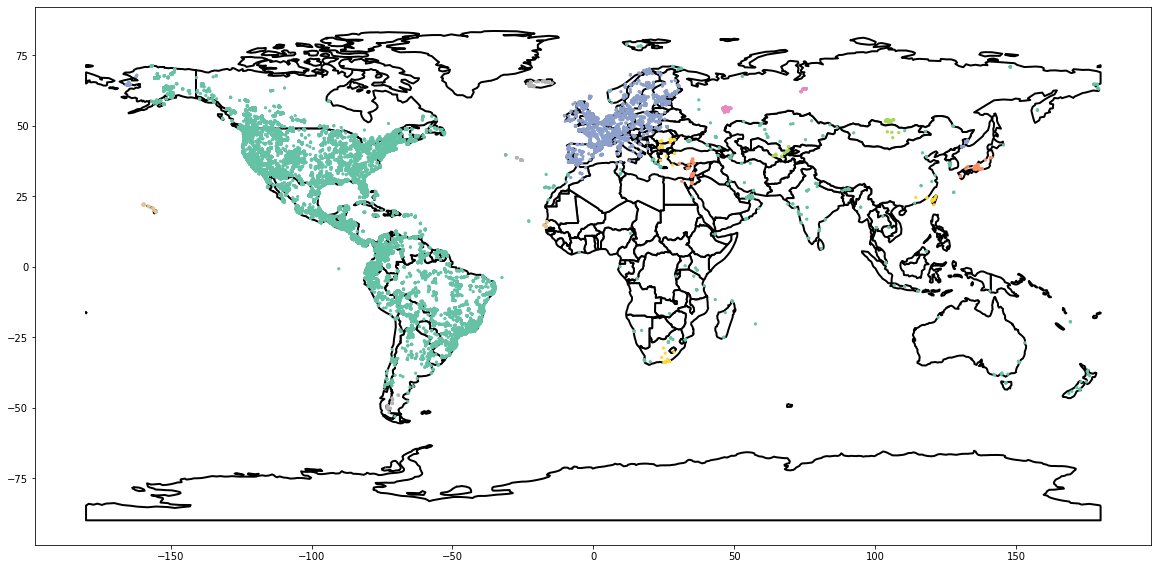

In [6]:
# Initiate DBSCAN with eps and min_samples and create clusters from the geodata. Here:
# eps         = radius of neighborhood
# min_samples = min number of points needed in an eps neighborhood of
#               a point for the point to be considered a core point
clusters_from_DBSCAN = DBSCAN(eps=4, min_samples=20).fit_predict(X)

# Create dataframe from cluster data and join with geodataframe
clusters_DBSCAN = pd.DataFrame(clusters_from_DBSCAN, columns=['cluster_DBSCAN'])
gdf_cd=gdf.join(clusters_DBSCAN)

# Initiate plot
fig, ax = plt.subplots(figsize = (20,16))

# Plot blank world map and overlay clusters on it.
world.plot(color='white', edgecolor='k', linewidth = 2, ax=ax)
gdf_cd.plot(column='cluster_DBSCAN', c=clusters_from_DBSCAN, cmap='Set2',
            markersize=5, ax=ax)
plt.show()

## Method 3: Filter by Country, Rating, Date

First we find the indices for the bird data from the US, Canada, or Mexico.

In [7]:
# Get the physical addresses associated with the latitude-longitude pairs in X
X_useful_loc = reverse_geocode.search(X)

# Create array with the country corresponding to each element in the training data
X_countries = np.array([d['country'] for d in X_useful_loc])

# North America Booleans
USA = X_countries == 'United States'
CAN = X_countries == 'Canada'
MEX = X_countries == 'Mexico'
NA = (USA | CAN | MEX)

# Indices corresponding to data from the US, Canada, or Mexico
X_NA_ind = np.where(NA)

Further filter the training data by date range and audio rating.

In [19]:
# Pull only North American data
train_meta_NA = train_meta.iloc[X_NA_ind[0]]

# Sort dates chronologically (for possible use later)
train_meta_NA_date_sort = train_meta_NA.sort_values(by='date')

# Convert valid dates to datetime and invalid to NAT
pd.to_datetime(train_meta_NA_date_sort["date"], errors='coerce')

# Date Range and audio rating threshold
start_date = "1900-1-1"
end_date = "2021-12-31"
min_rating = 3.5 # threshold for audio rating

# Create booleans for date range and audio rating
after_start_date = train_meta_NA_date_sort["date"] >= start_date
before_end_date = train_meta_NA_date_sort["date"] <= end_date
between_two_dates = after_start_date & before_end_date
above_min_rating = train_meta_NA_date_sort["rating"] >= min_rating

# Filter out data not in date range and below min_rating
train_meta_NA_good_date_rating = train_meta_NA_date_sort[between_two_dates & above_min_rating]

Now we visualize the filtered data on a map of North America. The color of each point on the map corresponds to primary label (bird type) for the audio file recorded at that location.

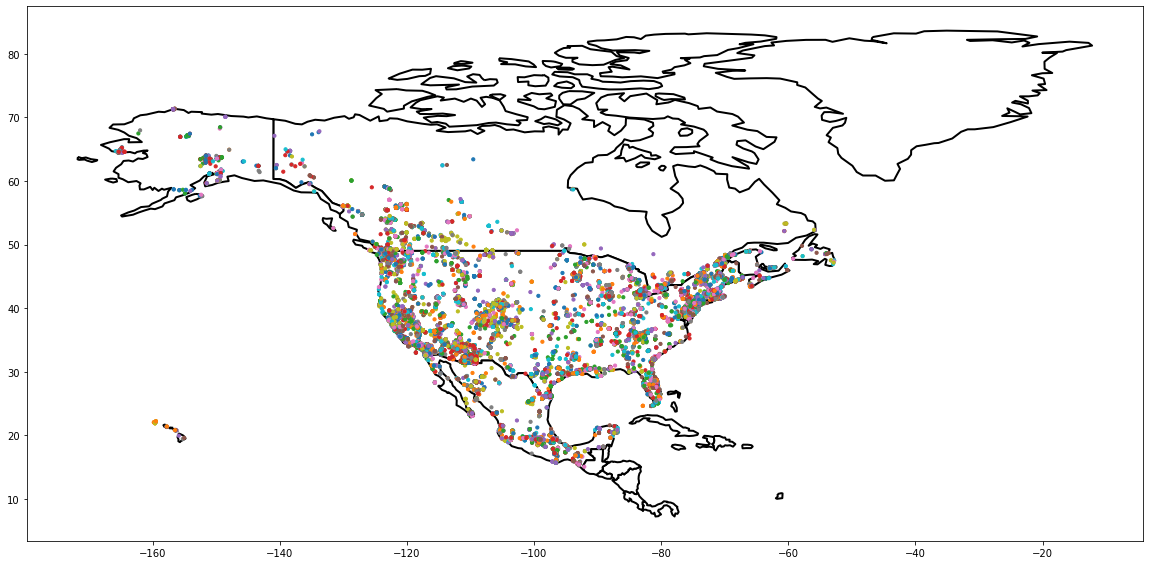

In [20]:
# Create a geodataframe from the filtered data 'train_meta_NA_good_date_rating'.
gdf_NA = gpd.GeoDataFrame(train_meta_NA_good_date_rating,
                          geometry=gpd.points_from_xy(train_meta_NA_good_date_rating.longitude,
                                                      train_meta_NA_good_date_rating.latitude))

# Initialize plot
fig, ax = plt.subplots(figsize = (20,16))

# Plot blank map of North America and overlay filtered data from 'gdf_NA' on it.
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
NA_fig = world[world.continent == "North America"]
NA_fig.plot(color='white',edgecolor='k', linewidth = 2, ax=ax)
gdf_NA.plot(column='primary_label', categorical=True, markersize=10, ax=ax)
plt.show()

In [10]:
# Take a look at the number of audio files per bird type in original unfiltered training set.
with pd.option_context('display.max_rows', 1000, 'display.max_columns', None):
    print(train_meta['common_name'].value_counts())

Red Crossbill                       500
European Starling                   500
Barn Swallow                        500
Gray-breasted Wood-Wren             500
House Sparrow                       500
Spotted Towhee                      500
Northern Cardinal                   500
Song Sparrow                        500
Curve-billed Thrasher               500
Common Raven                        500
House Wren                          500
Red-winged Blackbird                500
Mallard                             484
American Robin                      481
Bewick's Wren                       466
Carolina Wren                       464
Swainson's Thrush                   450
Rufous-browed Peppershrike          441
Brown-crested Flycatcher            406
Rufous-collared Sparrow             403
Common Yellowthroat                 398
Warbling Vireo                      391
Eurasian Collared-Dove              368
Dark-eyed Junco                     359
Great Kiskadee                      357


In [21]:
# Sort the filtered North American training set train_meta_NA_good_date_rating by
# number of audio files per bird type from highest to lowest. Then pull the bird
# names of the top num_bird_types.
num_bird_types = 20
with pd.option_context('display.max_rows', 1000, 'display.max_columns', None):
    names_to_use = train_meta_NA_good_date_rating['common_name'].value_counts()[:num_bird_types].index
    print(names_to_use.values)

['Song Sparrow' 'Spotted Towhee' 'Northern Cardinal'
 'Red-winged Blackbird' "Bewick's Wren" 'Curve-billed Thrasher'
 'American Robin' 'Carolina Wren' 'Common Yellowthroat' 'Marsh Wren'
 'Northern Mockingbird' "Swainson's Thrush" 'Warbling Vireo' 'Blue Jay'
 'Western Meadowlark' 'Dark-eyed Junco' 'Brown-crested Flycatcher'
 'Hermit Thrush' 'Yellow-breasted Chat' 'House Finch']


In [22]:
# Now we keep only the files corresponding to the birds in the names_to_use list.
most_data_avail = train_meta_NA_good_date_rating['common_name'].isin(names_to_use.values)
train_data_top_birds = train_meta_NA_good_date_rating[most_data_avail]
train_data_top_birds

,primary_label,latitude,longitude,common_name,date,filename,rating,geometry
8495,blujay,40.820812,-74.201669,Blue Jay,1983-03-00,XC67162.ogg,3.5,POINT (-74.20167 40.82081)
34397,marwre,49.301500,-122.698900,Marsh Wren,1989-04-30,XC511301.ogg,5.0,POINT (-122.69890 49.30150)
35940,norcar,30.652000,-96.167100,Northern Cardinal,1990-01-21,XC211157.ogg,4.0,POINT (-96.16710 30.65200)
13281,carwre,30.652100,-95.958600,Carolina Wren,1990-03-24,XC210728.ogg,5.0,POINT (-95.95860 30.65210)
18030,comyel,30.652000,-96.167100,Common Yellowthroat,1990-04-01,XC211134.ogg,3.5,POINT (-96.16710 30.65200)
...,...,...,...,...,...,...,...,...
19342,cubthr,19.324400,-98.967300,Curve-billed Thrasher,2021-01-30,XC618611.ogg,3.5,POINT (-98.96730 19.32440)
56897,wesmea,38.591100,-121.680600,Western Meadowlark,2021-01-30,XC619061.ogg,4.5,POINT (-121.68060 38.59110)
50997,spotow,37.441300,-122.231000,Spotted Towhee,2021-01-30,XC619056.ogg,3.5,POINT (-122.23100 37.44130)
6074,bewwre,17.057000,-96.764000,Bewick's Wren,2021-02-02,XC619255.ogg,3.5,POINT (-96.76400 17.05700)
